In [1]:
# !pip install -q transformers
# !pip install -q sentencepiece
# !pip install -q jiwer
# !pip install -q datasets
# !pip install -q evaluate
# !pip install -q -U accelerate
 
 
# !pip install -q matplotlib
# !pip install -q protobuf==3.20.1
# !pip install -q tensorboard

In [2]:
import os
import torch
import evaluate
import numpy as np
import pandas as pd
import glob as glob
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
 
 
from PIL import Image
from zipfile import ZipFile
from tqdm.notebook import tqdm
from dataclasses import dataclass
from torch.utils.data import Dataset
from urllib.request import urlretrieve
from transformers import (
    VisionEncoderDecoderModel,
    TrOCRProcessor,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    default_data_collator
)

In [3]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
 
seed_everything(42)
 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
import xml.etree.ElementTree as ET

In [10]:
def get_label(inkml_file_abs_path):
    tree = ET.parse(inkml_file_abs_path)
    root = tree.getroot()
    doc_namespace = "{http://www.w3.org/2003/InkML}"

    for child in root:
        if (child.tag == doc_namespace + 'annotation') and (child.attrib == {'type': 'truth'}):
            return child.text.strip(' $\t\n\r\x0b\x0c')

In [6]:
def get_traces_data(inkml_file_abs_path):

        traces_data = []

        tree = ET.parse(inkml_file_abs_path)
        root = tree.getroot()
        doc_namespace = "{http://www.w3.org/2003/InkML}"

        'Stores traces_all with their corresponding id'
        traces_all = [{'id': trace_tag.get('id'),
                        'coords': [[round(float(axis_coord)) if float(axis_coord).is_integer() else round(float(axis_coord) * 10000) \
                                        for axis_coord in coord[1:].split(' ')] if coord.startswith(' ') \
                                    else [round(float(axis_coord)) if float(axis_coord).is_integer() else round(float(axis_coord) * 10000) \
                                        for axis_coord in coord.split(' ')] \
                                for coord in (trace_tag.text).replace('\n', '').split(',')]} \
                                for trace_tag in root.findall(doc_namespace + 'trace')]

        'Sort traces_all list by id to make searching for references faster'
        traces_all.sort(key=lambda trace_dict: int(trace_dict['id']))

        'Always 1st traceGroup is a redundant wrapper'
        traceGroupWrapper = root.find(doc_namespace + 'traceGroup')

        if traceGroupWrapper is not None:
            for traceGroup in traceGroupWrapper.findall(doc_namespace + 'traceGroup'):

                label = traceGroup.find(doc_namespace + 'annotation').text
                id = traceGroup.get('{http://www.w3.org/XML/1998/namespace}id')     

                'traces of the current traceGroup'
                traces_curr = []
                for traceView in traceGroup.findall(doc_namespace + 'traceView'):

                    'Id reference to specific trace tag corresponding to currently considered label'
                    traceDataRef = int(traceView.get('traceDataRef'))

                    'Each trace is represented by a list of coordinates to connect'
                    single_trace = traces_all[traceDataRef]['coords']
                    traces_curr.append(single_trace)


                traces_data.append({'label': label, 'trace_group': traces_curr, 'id':id})

        else:
            'Consider Validation data that has no labels'
            [traces_data.append({'trace_group': [trace['coords']]}) for trace in traces_all]

        return traces_data

In [11]:
get_label('data_merged/001-equation000.inkml')

'y = Ax + A^2'

In [37]:
def get_image(file):
    traces = get_traces_data(file)
    fig, ax = plt.subplots()
    ax.invert_yaxis()
    ax.set_aspect('equal', adjustable='box')
    ax.set_axis_off()
    for elem in traces:
        ls = elem['trace_group']
        for subls in ls:
            data = np.array(subls)
            x,y=zip(*data)
            ax.plot(x,y,linewidth=2,c='black')
    fig.set_frameon(False)
    fig.canvas.draw()
    image = Image.frombytes('RGB', fig.canvas.get_width_height(),fig.canvas.tostring_rgb())
    w = image.width
    h = image.height
    if w<h:
        result = Image.new(image.mode, (h, h), (255,255,255))
        result.paste(image, (int((h-w)/2), 0))
        image = result
    elif h<w:
        result = Image.new(image.mode, (w, w), (255,255,255))
        result.paste(image, (0, int((w-h)/2)))
        image = result
    plt.close()
    return image

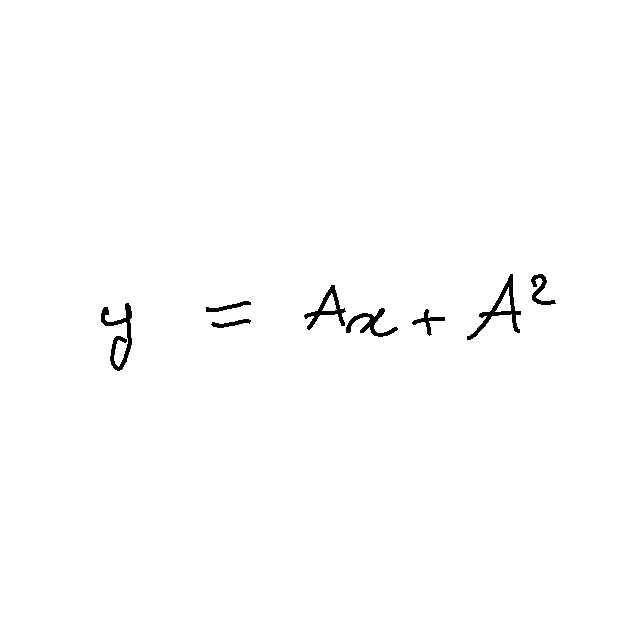

In [38]:
get_image('data_merged/001-equation000.inkml')

In [39]:
# Augmentations.
train_transforms = transforms.Compose([
    transforms.ColorJitter(brightness=.5, hue=.3),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
])

class CROHME_OCR_Dataset(Dataset):
    def __init__(self, files, processor, max_target_length=128) -> None:
        super().__init__()
        self.files = files
        self.processor = processor
        self.max_target_length = 128
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, index):
        file = self.files[index]
        text = get_label(file)
        image = get_image(file)
        image = train_transforms(image)
        pixel_values = self.processor(image, return_tensors='pt').pixel_values
        labels = self.processor.tokenizer(
            text,
            padding='max_length',
            max_length=self.max_target_length
        ).input_ids
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]
        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [42]:
from sklearn.model_selection import train_test_split
train_files, test_files = train_test_split(glob.glob('./data_merged/*.inkml'),test_size=.2)
print(len(train_files),len(test_files))

8680 2171


In [43]:
@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:    int = 48
    EPOCHS:        int = 35
    LEARNING_RATE: float = 0.00005
 
@dataclass(frozen=True)
class DatasetConfig:
    DATA_ROOT:     str = 'scut_data'
 
@dataclass(frozen=True)
class ModelConfig:
    MODEL_NAME: str = 'microsoft/trocr-small-printed'

In [44]:
processor = TrOCRProcessor.from_pretrained(ModelConfig.MODEL_NAME)
train_dataset = CROHME_OCR_Dataset(train_files,processor)
valid_dataset = CROHME_OCR_Dataset(test_files,processor)

preprocessor_config.json:   0%|          | 0.00/276 [00:00<?, ?B/s]

c:\Users\fioritjx\Anaconda3\envs\ml\lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\fioritjx\.cache\huggingface\hub\models--microsoft--trocr-small-printed. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Could not find image processor class in the image processor config or the model config. Loading 

tokenizer_config.json:   0%|          | 0.00/327 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

In [45]:
model = VisionEncoderDecoderModel.from_pretrained(ModelConfig.MODEL_NAME)
model.to(device)
print(model)
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

config.json:   0%|          | 0.00/4.21k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/246M [00:00<?, ?B/s]

c:\Users\fioritjx\Anaconda3\envs\ml\lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

VisionEncoderDecoderModel(
  (encoder): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTAttention(
            (attention): DeiTSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(

In [46]:
# Set special tokens used for creating the decoder_input_ids from the labels.
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# Set Correct vocab size.
model.config.vocab_size = model.config.decoder.vocab_size
model.config.eos_token_id = processor.tokenizer.sep_token_id
 
 
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [47]:
optimizer = optim.AdamW(
    model.parameters(), lr=TrainingConfig.LEARNING_RATE, weight_decay=0.0005
)

In [48]:
cer_metric = evaluate.load('cer')
 
 
def compute_cer(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions
 
 
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)
 
 
    cer = cer_metric.compute(predictions=pred_str, references=label_str)
 
 
    return {"cer": cer}

In [49]:
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy='epoch',
    per_device_train_batch_size=TrainingConfig.BATCH_SIZE,
    per_device_eval_batch_size=TrainingConfig.BATCH_SIZE,
    fp16=True,
    output_dir='seq2seq_model_printed/',
    logging_strategy='epoch',
    save_strategy='epoch',
    save_total_limit=5,
    report_to='tensorboard',
    num_train_epochs=TrainingConfig.EPOCHS
)

In [50]:
# Initialize trainer.
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_cer,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=default_data_collator
)

c:\Users\fioritjx\Anaconda3\envs\ml\lib\site-packages\transformers\models\trocr\processing_trocr.py:136: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


In [51]:
res = trainer.train()

  0%|          | 0/6335 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 368.00 MiB. GPU 0 has a total capacty of 4.00 GiB of which 0 bytes is free. Of the allocated memory 9.25 GiB is allocated by PyTorch, and 128.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
processor = TrOCRProcessor.from_pretrained(ModelConfig.MODEL_NAME)
trained_model = VisionEncoderDecoderModel.from_pretrained('seq2seq_model_printed/checkpoint-'+str(res.global_step)).to(device)

In [ ]:
def ocr(image, processor, model):
    """
    :param image: PIL Image.
    :param processor: Huggingface OCR processor.
    :param model: Huggingface OCR model.
 
 
    Returns:
        generated_text: the OCR'd text string.
    """
    # We can directly perform OCR on cropped images.
    pixel_values = processor(image, return_tensors='pt').pixel_values.to(device)
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_text